In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

%matplotlib inline

In [2]:
xytick_font = 18
xylabel_font = 24
legend_font = 16
# figsize = (9, 6)
figsize = (9, 3.5)

colors = [
    (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
    (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
    (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
    (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
]

In [3]:
mm_types_short = ["tracep1", "wifi-25"]
mm_types = ["tracep1-scaled10.0", "wifi-25-scaled15.0"]
seq_names_short = ["band2", "dance5", "office1", "pizza1", "toddler4"]
seq_names = [
    "160906_band2_with_ground",
    "170307_dance5_with_ground",
    "170915_office1_with_ground",
    "160906_pizza1_with_ground",
    "170915_toddler4_with_ground",
]
log_seq0 = [1, 0, 2, 1, 0]
log_seq1 = [0, 1, 0, 0, 1]
log_seq2 = [2, 2, 1, 2, 2]
log_seqs = [log_seq0, log_seq1, log_seq2]

start_end_frames0 = [(2, 5517), (34, 10000), (19, 5600), (1, 1413), (1, 3800)]
start_end_frames1 = [(2, 5000), (34, 10000), (19, 5600), (1, 1486), (1, 3800)]
start_end_frames2 = [(2, 5970), (34, 10000), (19, 5600), (1, 1029), (1, 3800)]
start_end_frames = [start_end_frames0, start_end_frames1, start_end_frames2]

input_dir = "/datassd/pipeline_cpp/client_tiled/e2e_quality/"
output_dir = "/home/lei/rajrup/KinectStream/Scripts/e2e_quality/plots/"

input_dir_mr = "/hdd/pipeline_meshreduce/e2e_quality/"

In [4]:
# Meshreduce

start_end_frames_mr = [(2, 5970), (34, 10000), (19, 5600), (1, 1486), (1, 3800)]

In [5]:
def calc_avg_pssim(
    df, start_frame, end_frame, offset_start=200, offset_end=50, with_stalls=True
):
    df = df.copy()
    df = df[df["Frame"] <= end_frame - offset_end]
    df = df[df["Frame"] >= start_frame + offset_start]

    pssim_geo = df["PSSIM_GEO_AB"].values
    pssim_color = df["PSSIM_COLOR_AB"].values

    num_stalls = 0
    num_render_frames = 0
    for frame_id in range(start_frame + offset_start, end_frame - offset_end + 1):
        if frame_id % 10 != 0:
            continue

        if frame_id in df["Frame"].values:
            num_render_frames += 1
        else:
            num_stalls += 1

    if with_stalls:
        num_frames = num_render_frames + num_stalls
    else:
        num_frames = num_render_frames

    stall_percent = 100.0 * num_stalls / (num_render_frames + num_stalls)

    avg_pssim_geo = np.sum(pssim_geo) / num_frames
    avg_pssim_color = np.sum(pssim_color) / num_frames
    return (
        avg_pssim_geo,
        avg_pssim_color,
        num_stalls,
        num_render_frames,
        num_frames,
        stall_percent,
    )

In [6]:
# Create a dataframe to store the results
column_names = [
    "Video",
    "Log ID",
    "Network Trace",
    "Draco_stalls",
    "Draco_geo_no_stalls",
    "Draco_geo_with_stalls",
    "Draco_color_no_stalls",
    "Draco_color_with_stalls",
    "Livo_nocull_stalls",
    "Livo_nocull_geo_no_stalls",
    "Livo_nocull_geo_with_stalls",
    "Livo_nocull_color_no_stalls",
    "Livo_nocull_color_with_stalls",
    "Livo_stalls",
    "Livo_geo_no_stalls",
    "Livo_geo_with_stalls",
    "Livo_color_no_stalls",
    "Livo_color_with_stalls",
    "Starline_stalls",
    "Starline_geo_no_stalls",
    "Starline_geo_with_stalls",
    "Starline_color_no_stalls",
    "Starline_color_with_stalls",
]

column_names_mr = [
    "Video",
    "Network Trace",
    "Meshreduce_geo_with_stalls",
    "Meshreduce_color_with_stalls",
]

data_df = pd.DataFrame(columns=column_names)
data_df_mr = pd.DataFrame(columns=column_names_mr)

In [7]:
for mm_type, mm_type_short in zip(mm_types, mm_types_short):
    for seq_name, seq_name_short, start_end_frame in zip(
        seq_names, seq_names_short, start_end_frames_mr
    ):
        print(start_end_frame)
        start_frame, end_frame = start_end_frame

        # Meshreduce
        pipeline_method = "meshreduce"
        culling = "s_nocull_c_nocull"

        pssim_file_path = os.path.join(
            input_dir_mr,
            f"mesh_to_ptcl/{seq_name}/{mm_type}/comp_draco_pointssim_{culling}/3D_pssim.csv",
        )

        mr_pssim_df = pd.read_csv(pssim_file_path)

        # replace NaN with 0
        mr_pssim_df.fillna(0, inplace=True)

        with_stalls = True
        (
            avg_pssim_geo,
            avg_pssim_color,
            num_stalls,
            num_render_frames,
            num_frames,
            stall_percent,
        ) = calc_avg_pssim(mr_pssim_df, start_frame, end_frame, with_stalls=with_stalls)

        print(
            f"Method:{pipeline_method}, avg_pssim_geo: {avg_pssim_geo}, avg_pssim_color: {avg_pssim_color}, stalls: {with_stalls}, stall_percent:{stall_percent}%, num_stalls: {num_stalls}, num_render_frames: {num_render_frames}, num_frames: {num_frames}"
        )

        mr_geo_no_stalls = avg_pssim_geo
        mr_color_no_stalls = avg_pssim_color

        data_df_mr = data_df_mr.append(
            {
                "Video": seq_name_short,
                "Network Trace": mm_type_short,
                "Meshreduce_geo_with_stalls": mr_geo_no_stalls,
                "Meshreduce_color_with_stalls": mr_color_no_stalls,
            },
            ignore_index=True,
        )

# Save the results
data_df_mr.to_csv(os.path.join(output_dir, "e2e_quality_meshreduce.csv"), index=False)

data_df_mr

(2, 5970)
Method:meshreduce, avg_pssim_geo: 64.15963286713286, avg_pssim_color: 74.78052447552447, stalls: True, stall_percent:7.1678321678321675%, num_stalls: 41, num_render_frames: 531, num_frames: 572
(34, 10000)
Method:meshreduce, avg_pssim_geo: 67.2947633744856, avg_pssim_color: 87.36117283950617, stalls: True, stall_percent:0.0%, num_stalls: 0, num_render_frames: 972, num_frames: 972
(19, 5600)
Method:meshreduce, avg_pssim_geo: 68.25559925093634, avg_pssim_color: 81.37816479400749, stalls: True, stall_percent:0.0%, num_stalls: 0, num_render_frames: 534, num_frames: 534
(1, 1486)
Method:meshreduce, avg_pssim_geo: 68.67975609756097, avg_pssim_color: 77.23520325203252, stalls: True, stall_percent:1.6260162601626016%, num_stalls: 2, num_render_frames: 121, num_frames: 123
(1, 3800)
Method:meshreduce, avg_pssim_geo: 68.22698591549295, avg_pssim_color: 85.08219718309859, stalls: True, stall_percent:0.0%, num_stalls: 0, num_render_frames: 355, num_frames: 355
(2, 5970)
Method:meshreduce

,Video,Network Trace,Meshreduce_geo_with_stalls,Meshreduce_color_with_stalls
0,band2,tracep1,64.159633,74.780524
1,dance5,tracep1,67.294763,87.361173
2,office1,tracep1,68.255599,81.378165
3,pizza1,tracep1,68.679756,77.235203
4,toddler4,tracep1,68.226986,85.082197
5,band2,wifi-25,63.434073,73.914318
6,dance5,wifi-25,66.360700,87.152685
7,office1,wifi-25,67.666348,80.868390
8,pizza1,wifi-25,68.210894,76.554634
9,toddler4,wifi-25,67.247493,84.510507


In [8]:
for log_seq, start_end_frame_seq in zip(log_seqs, start_end_frames):
    for mm_type, mm_type_short in zip(mm_types, mm_types_short):
        for seq_name, seq_name_short, start_end_frame, log_id in zip(
            seq_names, seq_names_short, start_end_frame_seq, log_seq
        ):
            print(start_end_frame)
            start_frame, end_frame = start_end_frame

            # DRACO
            pipeline_method = "draco"
            culling = "s_pcull_c_cull"

            pssim_file_path = os.path.join(
                input_dir,
                f"{pipeline_method}/{seq_name}/{mm_type}/comp_o3d_pointssim_{culling}/log{log_id}/3D_pssim.csv",
            )
            draco_pssim_df = pd.read_csv(pssim_file_path)

            # replace NaN with 0
            draco_pssim_df.fillna(0, inplace=True)

            with_stalls = False
            (
                avg_pssim_geo,
                avg_pssim_color,
                num_stalls,
                num_render_frames,
                num_frames,
                stall_percent,
            ) = calc_avg_pssim(
                draco_pssim_df, start_frame, end_frame, with_stalls=with_stalls
            )
            print(
                f"Method:{pipeline_method}, avg_pssim_geo: {avg_pssim_geo}, avg_pssim_color: {avg_pssim_color}, stalls: {with_stalls}, stall_percent:{stall_percent}%, num_stalls: {num_stalls}, num_render_frames: {num_render_frames}, num_frames: {num_frames}"
            )

            draco_geo_no_stalls = avg_pssim_geo
            draco_color_no_stalls = avg_pssim_color

            with_stalls = True
            (
                avg_pssim_geo,
                avg_pssim_color,
                num_stalls,
                num_render_frames,
                num_frames,
                stall_percent,
            ) = calc_avg_pssim(
                draco_pssim_df, start_frame, end_frame, with_stalls=with_stalls
            )

            print(
                f"Method:{pipeline_method}, avg_pssim_geo: {avg_pssim_geo}, avg_pssim_color: {avg_pssim_color}, stalls: {with_stalls}, stall_percent:{stall_percent}%, num_stalls: {num_stalls}, num_render_frames: {num_render_frames}, num_frames: {num_frames}"
            )

            draco_stalls = stall_percent
            draco_geo_with_stalls = avg_pssim_geo
            draco_color_with_stalls = avg_pssim_color

            # LIVO NOCULL

            pipeline_method = "livo_nocull"
            culling = "s_nocull_c_cull"

            pssim_file_path = os.path.join(
                input_dir,
                f"{pipeline_method}/{seq_name}/{mm_type}/comp_o3d_pointssim_{culling}/log{log_id}/3D_pssim.csv",
            )
            livo_nocull_pssim_df = pd.read_csv(pssim_file_path)

            # replace NaN with 0
            livo_nocull_pssim_df.fillna(0, inplace=True)

            with_stalls = False
            (
                avg_pssim_geo,
                avg_pssim_color,
                num_stalls,
                num_render_frames,
                num_frames,
                stall_percent,
            ) = calc_avg_pssim(
                livo_nocull_pssim_df, start_frame, end_frame, with_stalls=with_stalls
            )

            print(
                f"Method:{pipeline_method}, avg_pssim_geo: {avg_pssim_geo}, avg_pssim_color: {avg_pssim_color}, stalls: {with_stalls}, stall_percent:{stall_percent}%, num_stalls: {num_stalls}, num_render_frames: {num_render_frames}, num_frames: {num_frames}"
            )

            livo_nocull_geo_no_stalls = avg_pssim_geo
            livo_nocull_color_no_stalls = avg_pssim_color

            with_stalls = True

            (
                avg_pssim_geo,
                avg_pssim_color,
                num_stalls,
                num_render_frames,
                num_frames,
                stall_percent,
            ) = calc_avg_pssim(
                livo_nocull_pssim_df, start_frame, end_frame, with_stalls=with_stalls
            )

            print(
                f"Method:{pipeline_method}, avg_pssim_geo: {avg_pssim_geo}, avg_pssim_color: {avg_pssim_color}, stalls: {with_stalls}, stall_percent:{stall_percent}%, num_stalls: {num_stalls}, num_render_frames: {num_render_frames}, num_frames: {num_frames}"
            )

            livo_nocull_stalls = stall_percent
            livo_nocull_geo_with_stalls = avg_pssim_geo
            livo_nocull_color_with_stalls = avg_pssim_color

            # LIVO
            pipeline_method = "livo"
            culling = "s_kpcull10_c_cull"

            pssim_file_path = os.path.join(
                input_dir,
                f"{pipeline_method}/{seq_name}/{mm_type}/comp_o3d_pointssim_{culling}/log{log_id}/3D_pssim.csv",
            )
            livo_pssim_df = pd.read_csv(pssim_file_path)

            # replace NaN with 0
            livo_pssim_df.fillna(0, inplace=True)

            with_stalls = False

            (
                avg_pssim_geo,
                avg_pssim_color,
                num_stalls,
                num_render_frames,
                num_frames,
                stall_percent,
            ) = calc_avg_pssim(
                livo_pssim_df, start_frame, end_frame, with_stalls=with_stalls
            )

            print(
                f"Method:{pipeline_method}, avg_pssim_geo: {avg_pssim_geo}, avg_pssim_color: {avg_pssim_color}, stalls: {with_stalls}, stall_percent:{stall_percent}%, num_stalls: {num_stalls}, num_render_frames: {num_render_frames}, num_frames: {num_frames}"
            )

            livo_geo_no_stalls = avg_pssim_geo
            livo_color_no_stalls = avg_pssim_color

            with_stalls = True

            (
                avg_pssim_geo,
                avg_pssim_color,
                num_stalls,
                num_render_frames,
                num_frames,
                stall_percent,
            ) = calc_avg_pssim(
                livo_pssim_df, start_frame, end_frame, with_stalls=with_stalls
            )

            print(
                f"Method:{pipeline_method}, avg_pssim_geo: {avg_pssim_geo}, avg_pssim_color: {avg_pssim_color}, stalls: {with_stalls}, stall_percent:{stall_percent}%, num_stalls: {num_stalls}, num_render_frames: {num_render_frames}, num_frames: {num_frames}"
            )

            livo_stalls = stall_percent
            livo_geo_with_stalls = avg_pssim_geo
            livo_color_with_stalls = avg_pssim_color

            # Starline
            pipeline_method = "starline"
            culling = "s_nocull_c_cull"

            pssim_file_path = os.path.join(
                input_dir,
                f"{pipeline_method}/{seq_name}/{mm_type}/comp_o3d_pointssim_{culling}/log{log_id}/3D_pssim.csv",
            )
            starline_only_pssim_df = pd.read_csv(pssim_file_path)

            # replace NaN with 0
            starline_only_pssim_df.fillna(0, inplace=True)

            with_stalls = False

            (
                avg_pssim_geo,
                avg_pssim_color,
                num_stalls,
                num_render_frames,
                num_frames,
                stall_percent,
            ) = calc_avg_pssim(
                starline_only_pssim_df, start_frame, end_frame, with_stalls=with_stalls
            )

            print(
                f"Method:{pipeline_method}, avg_pssim_geo: {avg_pssim_geo}, avg_pssim_color: {avg_pssim_color}, stalls: {with_stalls}, stall_percent:{stall_percent}%, num_stalls: {num_stalls}, num_render_frames: {num_render_frames}, num_frames: {num_frames}"
            )

            starline_geo_no_stalls = avg_pssim_geo
            starline_color_no_stalls = avg_pssim_color

            with_stalls = True

            (
                avg_pssim_geo,
                avg_pssim_color,
                num_stalls,
                num_render_frames,
                num_frames,
                stall_percent,
            ) = calc_avg_pssim(
                starline_only_pssim_df, start_frame, end_frame, with_stalls=with_stalls
            )

            print(
                f"Method:{pipeline_method}, avg_pssim_geo: {avg_pssim_geo}, avg_pssim_color: {avg_pssim_color}, stalls: {with_stalls}, stall_percent:{stall_percent}%, num_stalls: {num_stalls}, num_render_frames: {num_render_frames}, num_frames: {num_frames}"
            )

            starline_stalls = stall_percent
            starline_geo_with_stalls = avg_pssim_geo
            starline_color_with_stalls = avg_pssim_color

            data_df = data_df.append(
                {
                    "Video": seq_name_short,
                    "Log ID": log_id,
                    "Network Trace": mm_type_short,
                    "Draco_stalls": draco_stalls,
                    "Draco_geo_no_stalls": draco_geo_no_stalls,
                    "Draco_geo_with_stalls": draco_geo_with_stalls,
                    "Draco_color_no_stalls": draco_color_no_stalls,
                    "Draco_color_with_stalls": draco_color_with_stalls,
                    "Livo_nocull_stalls": livo_nocull_stalls,
                    "Livo_nocull_geo_no_stalls": livo_nocull_geo_no_stalls,
                    "Livo_nocull_geo_with_stalls": livo_nocull_geo_with_stalls,
                    "Livo_nocull_color_no_stalls": livo_nocull_color_no_stalls,
                    "Livo_nocull_color_with_stalls": livo_nocull_color_with_stalls,
                    "Livo_stalls": livo_stalls,
                    "Livo_geo_no_stalls": livo_geo_no_stalls,
                    "Livo_geo_with_stalls": livo_geo_with_stalls,
                    "Livo_color_no_stalls": livo_color_no_stalls,
                    "Livo_color_with_stalls": livo_color_with_stalls,
                    "Starline_stalls": starline_stalls,
                    "Starline_geo_no_stalls": starline_geo_no_stalls,
                    "Starline_geo_with_stalls": starline_geo_with_stalls,
                    "Starline_color_no_stalls": starline_color_no_stalls,
                    "Starline_color_with_stalls": starline_color_with_stalls,
                },
                ignore_index=True,
            )

# Save the dataframe
data_df.to_csv(os.path.join(output_dir, "e2e_quality_draco_livo.csv"), index=False)

data_df

(2, 5517)
Method:draco, avg_pssim_geo: 97.17499999999998, avg_pssim_color: 98.48349999999999, stalls: False, stall_percent:88.59315589353612%, num_stalls: 466, num_render_frames: 60, num_frames: 60
Method:draco, avg_pssim_geo: 11.084600760456272, avg_pssim_color: 11.233859315589353, stalls: True, stall_percent:88.59315589353612%, num_stalls: 466, num_render_frames: 60, num_frames: 526
Method:livo_nocull, avg_pssim_geo: 91.0489292543021, avg_pssim_color: 80.4221223709369, stalls: False, stall_percent:0.5703422053231939%, num_stalls: 3, num_render_frames: 523, num_frames: 523
Method:livo_nocull, avg_pssim_geo: 90.52963878326996, avg_pssim_color: 79.96344106463879, stalls: True, stall_percent:0.5703422053231939%, num_stalls: 3, num_render_frames: 523, num_frames: 526
Method:livo, avg_pssim_geo: 91.0307619047619, avg_pssim_color: 80.47398095238096, stalls: False, stall_percent:0.19011406844106463%, num_stalls: 1, num_render_frames: 525, num_frames: 525
Method:livo, avg_pssim_geo: 90.857699

Method:starline, avg_pssim_geo: 86.69856995884774, avg_pssim_color: 93.25900205761317, stalls: False, stall_percent:0.0%, num_stalls: 0, num_render_frames: 972, num_frames: 972
Method:starline, avg_pssim_geo: 86.69856995884774, avg_pssim_color: 93.25900205761317, stalls: True, stall_percent:0.0%, num_stalls: 0, num_render_frames: 972, num_frames: 972
(19, 5600)
Method:draco, avg_pssim_geo: 91.20076086956519, avg_pssim_color: 96.68369565217391, stalls: False, stall_percent:82.77153558052434%, num_stalls: 442, num_render_frames: 92, num_frames: 92
Method:draco, avg_pssim_geo: 15.712490636704116, avg_pssim_color: 16.657116104868912, stalls: True, stall_percent:82.77153558052434%, num_stalls: 442, num_render_frames: 92, num_frames: 534
Method:livo_nocull, avg_pssim_geo: 90.97312380952381, avg_pssim_color: 84.72775238095238, stalls: False, stall_percent:1.6853932584269662%, num_stalls: 9, num_render_frames: 525, num_frames: 525
Method:livo_nocull, avg_pssim_geo: 89.43986891385768, avg_pssim

,Video,Log ID,Network Trace,Draco_stalls,Draco_geo_no_stalls,Draco_geo_with_stalls,Draco_color_no_stalls,Draco_color_with_stalls,Livo_nocull_stalls,Livo_nocull_geo_no_stalls,...,Livo_stalls,Livo_geo_no_stalls,Livo_geo_with_stalls,Livo_color_no_stalls,Livo_color_with_stalls,Starline_stalls,Starline_geo_no_stalls,Starline_geo_with_stalls,Starline_color_no_stalls,Starline_color_with_stalls
0,band2,1,tracep1,88.593156,97.175000,11.084601,98.483500,11.233859,0.570342,91.048929,...,0.190114,91.030762,90.857700,80.473981,80.320989,0.000000,85.928384,85.928384,80.315342,80.315342
1,dance5,0,tracep1,37.757202,97.096579,60.435628,99.382826,61.858652,0.411523,91.905651,...,0.000000,90.955062,90.955062,93.565514,93.565514,0.000000,86.698570,86.698570,93.259002,93.259002
2,office1,2,tracep1,82.771536,91.200761,15.712491,96.683696,16.657116,1.685393,90.973124,...,0.000000,91.128277,91.128277,84.954588,84.954588,0.000000,85.646236,85.646236,84.383670,84.383670
3,pizza1,1,tracep1,73.275862,89.039677,23.795086,95.317097,25.472672,7.758621,89.335981,...,0.000000,89.983793,89.983793,78.922069,78.922069,0.000000,85.643190,85.643190,78.383017,78.383017
4,toddler4,0,tracep1,85.633803,75.188627,10.801746,94.487059,13.574197,2.816901,91.855768,...,0.000000,91.355606,91.355606,88.820817,88.820817,0.000000,86.739211,86.739211,88.348563,88.348563
5,band2,1,wifi-25,88.593156,95.651667,10.910837,97.419167,11.112452,14.068441,83.051748,...,2.661597,86.638477,84.332510,78.852187,76.753460,74.714829,80.866767,20.447300,79.774662,20.171160
6,dance5,0,wifi-25,37.757202,95.373554,59.363169,98.998331,61.619331,7.716049,86.995953,...,1.543210,90.260094,88.867191,93.308098,91.868158,63.786008,75.655057,27.397716,89.499261,32.411255
7,office1,2,wifi-25,82.771536,85.933261,14.804981,94.640109,16.305037,13.108614,82.999073,...,1.685393,87.112571,85.644382,83.225771,81.823090,79.588015,77.634037,15.846648,84.199725,17.186835
8,pizza1,1,wifi-25,73.275862,86.216452,23.040603,93.904194,25.095086,29.310345,83.046463,...,6.034483,86.885229,81.642155,77.522110,72.844052,61.206897,73.636667,28.565948,76.357778,29.621552
9,toddler4,0,wifi-25,85.633803,72.028431,10.347746,93.926471,13.493662,9.859155,86.267938,...,1.408451,88.918829,87.666451,88.109171,86.868197,60.845070,84.205612,32.970648,87.966619,34.443268


In [9]:
seq_names = ["band2", "dance5", "office1", "pizza1", "toddler4"]

stalls_dict = {}
pssim_geo_dict = {}
pssim_color_dict = {}
for seq_name in seq_names:
    df = data_df[data_df["Video"] == seq_name]
    df_mr = data_df_mr[data_df_mr["Video"] == seq_name]
    stalls_dict[seq_name] = {
        "mean_draco_stalls": df["Draco_stalls"].mean(),
        "std_draco_stalls": df["Draco_stalls"].std(),
        "mean_livo_nocull_stalls": df["Livo_nocull_stalls"].mean(),
        "std_livo_nocull_stalls": df["Livo_nocull_stalls"].std(),
        "mean_livo_stalls": df["Livo_stalls"].mean(),
        "std_livo_stalls": df["Livo_stalls"].std(),
    }
    pssim_geo_dict[seq_name] = {
        "mean_draco_geo_no_stalls": df["Draco_geo_no_stalls"].mean(),
        "std_draco_geo_no_stalls": df["Draco_geo_no_stalls"].std(),
        "mean_livo_nocull_geo_no_stalls": df["Livo_nocull_geo_no_stalls"].mean(),
        "std_livo_nocull_geo_no_stalls": df["Livo_nocull_geo_no_stalls"].std(),
        "mean_livo_geo_no_stalls": df["Livo_geo_no_stalls"].mean(),
        "std_livo_geo_no_stalls": df["Livo_geo_no_stalls"].std(),
        "mean_draco_geo_with_stalls": df["Draco_geo_with_stalls"].mean(),
        "std_draco_geo_with_stalls": df["Draco_geo_with_stalls"].std(),
        "mean_livo_nocull_geo_with_stalls": df["Livo_nocull_geo_with_stalls"].mean(),
        "std_livo_nocull_geo_with_stalls": df["Livo_nocull_geo_with_stalls"].std(),
        "mean_livo_geo_with_stalls": df["Livo_geo_with_stalls"].mean(),
        "std_livo_geo_with_stalls": df["Livo_geo_with_stalls"].std(),
        "mean_meshreduce_geo_with_stalls": df_mr["Meshreduce_geo_with_stalls"].mean(),
        "std_meshreduce_geo_with_stalls": df_mr["Meshreduce_geo_with_stalls"].std(),
    }
    pssim_color_dict[seq_name] = {
        "mean_draco_color_no_stalls": df["Draco_color_no_stalls"].mean(),
        "std_draco_color_no_stalls": df["Draco_color_no_stalls"].std(),
        "mean_livo_nocull_color_no_stalls": df["Livo_nocull_color_no_stalls"].mean(),
        "std_livo_nocull_color_no_stalls": df["Livo_nocull_color_no_stalls"].std(),
        "mean_livo_color_no_stalls": df["Livo_color_no_stalls"].mean(),
        "std_livo_color_no_stalls": df["Livo_color_no_stalls"].std(),
        "mean_draco_color_with_stalls": df["Draco_color_with_stalls"].mean(),
        "std_draco_color_with_stalls": df["Draco_color_with_stalls"].std(),
        "mean_livo_nocull_color_with_stalls": df[
            "Livo_nocull_color_with_stalls"
        ].mean(),
        "std_livo_nocull_color_with_stalls": df["Livo_nocull_color_with_stalls"].std(),
        "mean_livo_color_with_stalls": df["Livo_color_with_stalls"].mean(),
        "std_livo_color_with_stalls": df["Livo_color_with_stalls"].std(),
        "mean_meshreduce_color_with_stalls": df_mr[
            "Meshreduce_color_with_stalls"
        ].mean(),
        "std_meshreduce_color_with_stalls": df_mr["Meshreduce_color_with_stalls"].std(),
    }

/tmp/ipykernel_824424/1009210683.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0, 101, 20), fontsize=xytick_font)


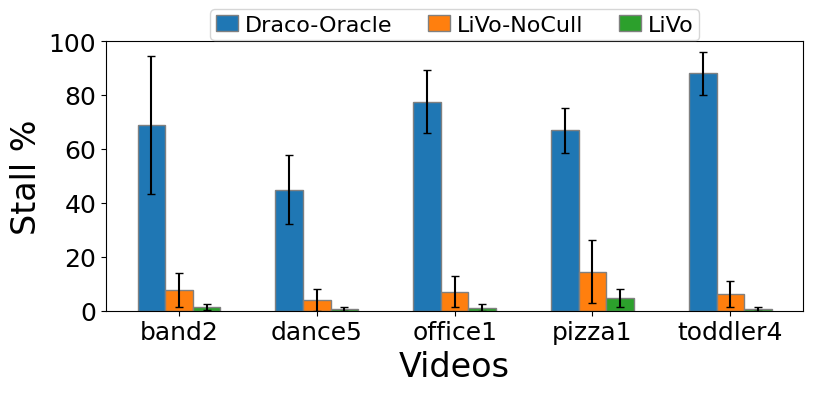

In [10]:
# Plot the stalls for videos

fig, ax = plt.subplots(1, 1, figsize=figsize)

barWidth = 0.2

r1 = np.arange(len(seq_names))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]


mean_draco_stalls = [
    stalls_dict[seq_name]["mean_draco_stalls"] for seq_name in seq_names
]
std_draco_stalls = [stalls_dict[seq_name]["std_draco_stalls"] for seq_name in seq_names]
ax.bar(
    r1,
    mean_draco_stalls,
    yerr=std_draco_stalls,
    width=barWidth,
    edgecolor="grey",
    label="Draco-Oracle",
    capsize=3,
    color=colors[0],
)

mean_livo_nocull_stalls = [
    stalls_dict[seq_name]["mean_livo_nocull_stalls"] for seq_name in seq_names
]
std_livo_nocull_stalls = [
    stalls_dict[seq_name]["std_livo_nocull_stalls"] for seq_name in seq_names
]
ax.bar(
    r2,
    mean_livo_nocull_stalls,
    yerr=std_livo_nocull_stalls,
    width=barWidth,
    edgecolor="grey",
    label="LiVo-NoCull",
    capsize=3,
    color=colors[2],
)

mean_livo_stalls = [stalls_dict[seq_name]["mean_livo_stalls"] for seq_name in seq_names]
std_livo_stalls = [stalls_dict[seq_name]["std_livo_stalls"] for seq_name in seq_names]
ax.bar(
    r3,
    mean_livo_stalls,
    yerr=std_livo_stalls,
    width=barWidth,
    edgecolor="grey",
    label="LiVo",
    capsize=3,
    color=colors[3],
)

ax.set_xticks(r2)
ax.set_xticklabels(seq_names)
ax.set_ylabel("Stall %", fontsize=xylabel_font)
ax.set_xlabel("Videos", fontsize=xylabel_font)
ax.set_yticklabels(np.arange(0, 101, 20), fontsize=xytick_font)
ax.set_xticklabels(seq_names, fontsize=xytick_font)
ax.set_ylim(0, 100)

legend = plt.legend(
    loc="upper center",
    handlelength=1,
    handletextpad=0.3,
    columnspacing=1.6,
    ncol=4,
    bbox_to_anchor=(0.5, 1.16),
    fontsize=legend_font,
    borderpad=0.25,
)

plt.show()

# Save figure to pdf file
fig.savefig(
    os.path.join(output_dir, "stalls.pdf"),
    bbox_inches="tight",
)

/tmp/ipykernel_824424/2602642033.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0, 101, 20), fontsize=xytick_font)


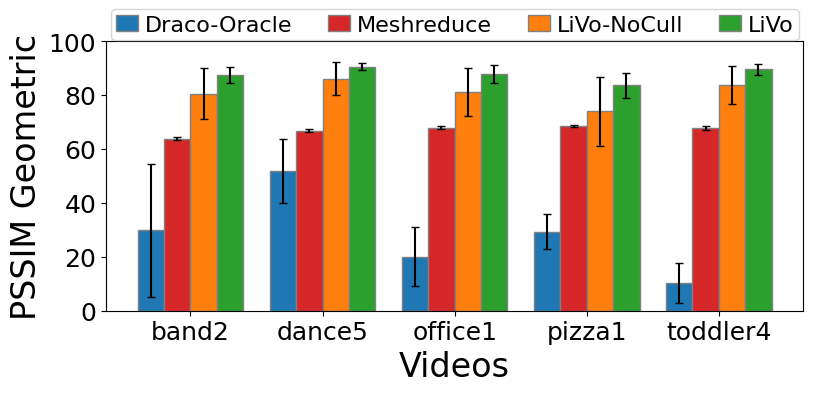

In [11]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

barWidth = 0.2

r1 = np.arange(len(seq_names))
r2 = np.array([x + barWidth for x in r1])
r3 = np.array([x + barWidth for x in r2])
r4 = np.array([x + barWidth for x in r3])

xticks = np.array([x + barWidth / 2.0 for x in r2])
# r5 = np.array([x + barWidth for x in r4])
# r6 = np.array([x + barWidth for x in r5])

# mean_draco_geo_no_stalls = [pssim_geo_dict[seq_name]["mean_draco_geo_no_stalls"] for seq_name in seq_names]
# std_draco_geo_no_stalls = [pssim_geo_dict[seq_name]["std_draco_geo_no_stalls"] for seq_name in seq_names]
# ax.bar(r1, mean_draco_geo_no_stalls, yerr=std_draco_geo_no_stalls, width=barWidth, edgecolor='grey', label='Draco_no_stalls', capsize=3)

mean_draco_geo_with_stalls = [
    pssim_geo_dict[seq_name]["mean_draco_geo_with_stalls"] for seq_name in seq_names
]
std_draco_geo_with_stalls = [
    pssim_geo_dict[seq_name]["std_draco_geo_with_stalls"] for seq_name in seq_names
]
ax.bar(
    r1,
    mean_draco_geo_with_stalls,
    yerr=std_draco_geo_with_stalls,
    width=barWidth,
    edgecolor="grey",
    label="Draco-Oracle",
    capsize=3,
    color=colors[0],
)

mean_meshreduce_geo_with_stalls = [
    pssim_geo_dict[seq_name]["mean_meshreduce_geo_with_stalls"]
    for seq_name in seq_names
]
std_meshreduce_geo_with_stalls = [
    pssim_geo_dict[seq_name]["std_meshreduce_geo_with_stalls"] for seq_name in seq_names
]

ax.bar(
    r2,
    mean_meshreduce_geo_with_stalls,
    yerr=std_meshreduce_geo_with_stalls,
    width=barWidth,
    edgecolor="grey",
    label="Meshreduce",
    capsize=3,
    color=colors[1],
)

# mean_livo_nocull_geo_no_stalls = [pssim_geo_dict[seq_name]["mean_livo_nocull_geo_no_stalls"] for seq_name in seq_names]
# std_livo_nocull_geo_no_stalls = [pssim_geo_dict[seq_name]["std_livo_nocull_geo_no_stalls"] for seq_name in seq_names]
# ax.bar(r3, mean_livo_nocull_geo_no_stalls, yerr=std_livo_nocull_geo_no_stalls, width=barWidth, edgecolor='grey', label='LiVo_nocull_no_stalls', capsize=3)

mean_livo_nocull_geo_with_stalls = [
    pssim_geo_dict[seq_name]["mean_livo_nocull_geo_with_stalls"]
    for seq_name in seq_names
]
std_livo_nocull_geo_with_stalls = [
    pssim_geo_dict[seq_name]["std_livo_nocull_geo_with_stalls"]
    for seq_name in seq_names
]
ax.bar(
    r3,
    mean_livo_nocull_geo_with_stalls,
    yerr=std_livo_nocull_geo_with_stalls,
    width=barWidth,
    edgecolor="grey",
    label="LiVo-NoCull",
    capsize=3,
    color=colors[2],
)

# mean_livo_geo_no_stalls = [pssim_geo_dict[seq_name]["mean_livo_geo_no_stalls"] for seq_name in seq_names]
# std_livo_geo_no_stalls = [pssim_geo_dict[seq_name]["std_livo_geo_no_stalls"] for seq_name in seq_names]
# ax.bar(r5, mean_livo_geo_no_stalls, yerr=std_livo_geo_no_stalls, width=barWidth, edgecolor='grey', label='LiVo_no_stalls', capsize=3)

mean_livo_geo_with_stalls = [
    pssim_geo_dict[seq_name]["mean_livo_geo_with_stalls"] for seq_name in seq_names
]
std_livo_geo_with_stalls = [
    pssim_geo_dict[seq_name]["std_livo_geo_with_stalls"] for seq_name in seq_names
]
ax.bar(
    r4,
    mean_livo_geo_with_stalls,
    yerr=std_livo_geo_with_stalls,
    width=barWidth,
    edgecolor="grey",
    label="LiVo",
    capsize=3,
    color=colors[3],
)

ax.set_xticks(xticks)
ax.set_xticklabels(seq_names)
ax.set_ylabel("PSSIM Geometric", fontsize=xylabel_font)
ax.set_xlabel("Videos", fontsize=xylabel_font)
ax.set_ylim(0, 100)
ax.set_yticklabels(np.arange(0, 101, 20), fontsize=xytick_font)
ax.set_xticklabels(seq_names, fontsize=xytick_font)
legend = plt.legend(
    loc="upper center",
    handlelength=1,
    handletextpad=0.3,
    columnspacing=1.6,
    ncol=4,
    bbox_to_anchor=(0.5, 1.16),
    fontsize=legend_font,
    borderpad=0.25,
)

plt.show()

# Save figure to pdf file
fig.savefig(
    os.path.join(output_dir, "pssim_geo_baselines.pdf"),
    bbox_inches="tight",
)

/tmp/ipykernel_824424/65461365.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0, 101, 20), fontsize=xytick_font)


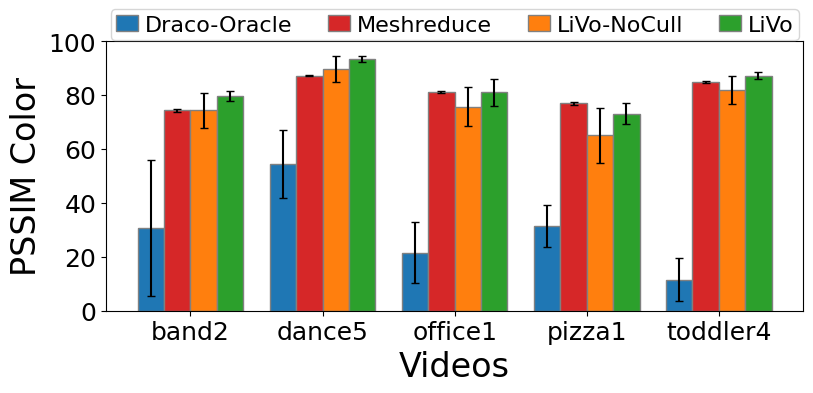

In [12]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

barWidth = 0.2

r1 = np.arange(len(seq_names))
r2 = np.array([x + barWidth for x in r1])
r3 = np.array([x + barWidth for x in r2])
r4 = np.array([x + barWidth for x in r3])

xticks = np.array([x + barWidth / 2.0 for x in r2])
# r5 = np.array([x + barWidth for x in r4])
# r6 = np.array([x + barWidth for x in r5])

# mean_draco_color_no_stalls = [pssim_color_dict[seq_name]["mean_draco_color_no_stalls"] for seq_name in seq_names]
# std_draco_color_no_stalls = [pssim_color_dict[seq_name]["std_draco_color_no_stalls"] for seq_name in seq_names]
# ax.bar(r1, mean_draco_color_no_stalls, yerr=std_draco_color_no_stalls, width=barWidth, edgecolor='grey', label='Draco_no_stalls', capsize=3)

mean_draco_color_with_stalls = [
    pssim_color_dict[seq_name]["mean_draco_color_with_stalls"] for seq_name in seq_names
]
std_draco_color_with_stalls = [
    pssim_color_dict[seq_name]["std_draco_color_with_stalls"] for seq_name in seq_names
]
rect_draco = ax.bar(
    r1,
    mean_draco_color_with_stalls,
    yerr=std_draco_color_with_stalls,
    width=barWidth,
    edgecolor="grey",
    label="Draco-Oracle",
    capsize=3,
    color=colors[0],
)

mean_meshreduce_color_with_stalls = [
    pssim_color_dict[seq_name]["mean_meshreduce_color_with_stalls"]
    for seq_name in seq_names
]
std_meshreduce_color_with_stalls = [
    pssim_color_dict[seq_name]["std_meshreduce_color_with_stalls"]
    for seq_name in seq_names
]

rect_meshreduce = ax.bar(
    r2,
    mean_meshreduce_color_with_stalls,
    yerr=std_meshreduce_color_with_stalls,
    width=barWidth,
    edgecolor="grey",
    label="Meshreduce",
    capsize=3,
    color=colors[1],
)

# mean_livo_nocull_color_no_stalls = [pssim_color_dict[seq_name]["mean_livo_nocull_color_no_stalls"] for seq_name in seq_names]
# std_livo_nocull_color_no_stalls = [pssim_color_dict[seq_name]["std_livo_nocull_color_no_stalls"] for seq_name in seq_names]
# ax.bar(r3, mean_livo_nocull_color_no_stalls, yerr=std_livo_nocull_color_no_stalls, width=barWidth, edgecolor='grey', label='LiVo_nocull_no_stalls', capsize=3)

mean_livo_nocull_color_with_stalls = [
    pssim_color_dict[seq_name]["mean_livo_nocull_color_with_stalls"]
    for seq_name in seq_names
]
std_livo_nocull_color_with_stalls = [
    pssim_color_dict[seq_name]["std_livo_nocull_color_with_stalls"]
    for seq_name in seq_names
]
rect_livo_nocull = ax.bar(
    r3,
    mean_livo_nocull_color_with_stalls,
    yerr=std_livo_nocull_color_with_stalls,
    width=barWidth,
    edgecolor="grey",
    label="LiVo-NoCull",
    capsize=3,
    color=colors[2],
)

# mean_livo_color_no_stalls = [pssim_color_dict[seq_name]["mean_livo_color_no_stalls"] for seq_name in seq_names]
# std_livo_color_no_stalls = [pssim_color_dict[seq_name]["std_livo_color_no_stalls"] for seq_name in seq_names]
# ax.bar(r5, mean_livo_color_no_stalls, yerr=std_livo_color_no_stalls, width=barWidth, edgecolor='grey', label='LiVo_no_stalls', capsize=3)

mean_livo_color_with_stalls = [
    pssim_color_dict[seq_name]["mean_livo_color_with_stalls"] for seq_name in seq_names
]
std_livo_color_with_stalls = [
    pssim_color_dict[seq_name]["std_livo_color_with_stalls"] for seq_name in seq_names
]
rect_livo = ax.bar(
    r4,
    mean_livo_color_with_stalls,
    yerr=std_livo_color_with_stalls,
    width=barWidth,
    edgecolor="grey",
    label="LiVo",
    capsize=3,
    color=colors[3],
)

ax.set_xticks(xticks)
ax.set_xticklabels(seq_names)
ax.set_ylabel("PSSIM Color", fontsize=xylabel_font)
ax.set_xlabel("Videos", fontsize=xylabel_font)
ax.set_ylim(0, 100)
ax.set_yticklabels(np.arange(0, 101, 20), fontsize=xytick_font)
ax.set_xticklabels(seq_names, fontsize=xytick_font)
legend = plt.legend(
    loc="upper center",
    handlelength=1,
    handletextpad=0.3,
    columnspacing=1.6,
    ncol=4,
    bbox_to_anchor=(0.5, 1.16),
    fontsize=legend_font,
    borderpad=0.25,
)

plt.show()

# Get color from the bars
# colors = [
#     rect_draco.patches[0].get_facecolor(),
#     rect_meshreduce.patches[0].get_facecolor(),
#     rect_livo_nocull.patches[0].get_facecolor(),
#     rect_livo.patches[0].get_facecolor(),
# ]

# Save figure to pdf file
fig.savefig(
    os.path.join(output_dir, "pssim_color_baselines.pdf"),
    bbox_inches="tight",
)

/tmp/ipykernel_824424/3836943361.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0, 101, 20), fontsize=xytick_font)


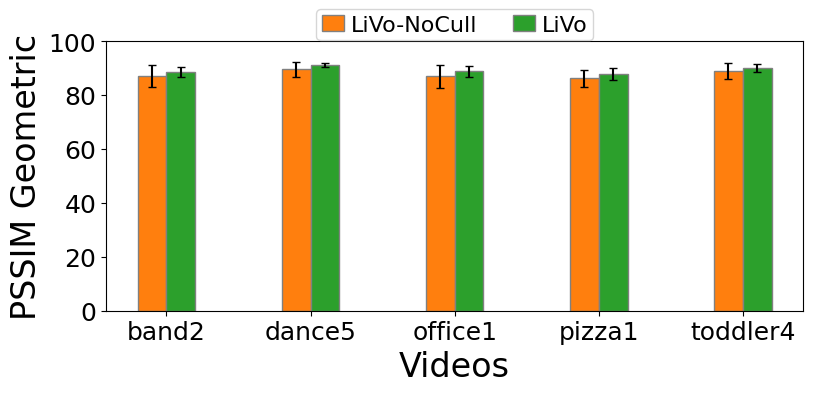

In [13]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

barWidth = 0.2

r1 = np.arange(len(seq_names))
r2 = np.array([x + barWidth for x in r1])
# r3 = np.array([x + barWidth for x in r2])
# r4 = np.array([x + barWidth for x in r3])
# r5 = np.array([x + barWidth for x in r4])
# r6 = np.array([x + barWidth for x in r5])

# mean_draco_geo_no_stalls = [pssim_geo_dict[seq_name]["mean_draco_geo_no_stalls"] for seq_name in seq_names]
# std_draco_geo_no_stalls = [pssim_geo_dict[seq_name]["std_draco_geo_no_stalls"] for seq_name in seq_names]
# ax.bar(r1, mean_draco_geo_no_stalls, yerr=std_draco_geo_no_stalls, width=barWidth, edgecolor='grey', label='Draco_no_stalls', capsize=3)

# mean_draco_geo_with_stalls = [pssim_geo_dict[seq_name]["mean_draco_geo_with_stalls"] for seq_name in seq_names]
# std_draco_geo_with_stalls = [pssim_geo_dict[seq_name]["std_draco_geo_with_stalls"] for seq_name in seq_names]
# ax.bar(r2, mean_draco_geo_with_stalls, yerr=std_draco_geo_with_stalls, width=barWidth, edgecolor='grey', label='Draco_with_stalls', capsize=3)

mean_livo_nocull_geo_no_stalls = [
    pssim_geo_dict[seq_name]["mean_livo_nocull_geo_no_stalls"] for seq_name in seq_names
]
std_livo_nocull_geo_no_stalls = [
    pssim_geo_dict[seq_name]["std_livo_nocull_geo_no_stalls"] for seq_name in seq_names
]
ax.bar(
    r1,
    mean_livo_nocull_geo_no_stalls,
    yerr=std_livo_nocull_geo_no_stalls,
    width=barWidth,
    edgecolor="grey",
    label="LiVo-NoCull",
    capsize=3,
    color=colors[2],
)

# mean_livo_nocull_geo_with_stalls = [pssim_geo_dict[seq_name]["mean_livo_nocull_geo_with_stalls"] for seq_name in seq_names]
# std_livo_nocull_geo_with_stalls = [pssim_geo_dict[seq_name]["std_livo_nocull_geo_with_stalls"] for seq_name in seq_names]
# ax.bar(r4, mean_livo_nocull_geo_with_stalls, yerr=std_livo_nocull_geo_with_stalls, width=barWidth, edgecolor='grey', label='LiVo_nocull_with_stalls', capsize=3)

mean_livo_geo_no_stalls = [
    pssim_geo_dict[seq_name]["mean_livo_geo_no_stalls"] for seq_name in seq_names
]
std_livo_geo_no_stalls = [
    pssim_geo_dict[seq_name]["std_livo_geo_no_stalls"] for seq_name in seq_names
]
ax.bar(
    r2,
    mean_livo_geo_no_stalls,
    yerr=std_livo_geo_no_stalls,
    width=barWidth,
    edgecolor="grey",
    label="LiVo",
    capsize=3,
    color=colors[3],
)

# mean_livo_geo_with_stalls = [pssim_geo_dict[seq_name]["mean_livo_geo_with_stalls"] for seq_name in seq_names]
# std_livo_geo_with_stalls = [pssim_geo_dict[seq_name]["std_livo_geo_with_stalls"] for seq_name in seq_names]
# ax.bar(r6, mean_livo_geo_with_stalls, yerr=std_livo_geo_with_stalls, width=barWidth, edgecolor='grey', label='LiVo_with_stalls', capsize=3)

ax.set_xticks(r1 + barWidth / 2)
ax.set_xticklabels(seq_names)
ax.set_ylabel("PSSIM Geometric", fontsize=xylabel_font)
ax.set_xlabel("Videos", fontsize=xylabel_font)
ax.set_ylim(0, 100)
ax.set_yticklabels(np.arange(0, 101, 20), fontsize=xytick_font)
ax.set_xticklabels(seq_names, fontsize=xytick_font)
legend = plt.legend(
    loc="upper center",
    handlelength=1,
    handletextpad=0.3,
    columnspacing=1.6,
    ncol=4,
    bbox_to_anchor=(0.5, 1.16),
    fontsize=legend_font,
    borderpad=0.25,
)

plt.show()

# Save figure to pdf file
fig.savefig(
    os.path.join(output_dir, "pssim_geo_without_stalls.pdf"),
    bbox_inches="tight",
)

# Comment: We get quality imporvement as a result of culling

In [14]:
# data_df = pd.read_csv(
#     "/home/lei/rajrup/KinectStream/data/quant_quality/pssim_starline_livo.csv"
# )

In [15]:
data_df

,Video,Log ID,Network Trace,Draco_stalls,Draco_geo_no_stalls,Draco_geo_with_stalls,Draco_color_no_stalls,Draco_color_with_stalls,Livo_nocull_stalls,Livo_nocull_geo_no_stalls,...,Livo_stalls,Livo_geo_no_stalls,Livo_geo_with_stalls,Livo_color_no_stalls,Livo_color_with_stalls,Starline_stalls,Starline_geo_no_stalls,Starline_geo_with_stalls,Starline_color_no_stalls,Starline_color_with_stalls
0,band2,1,tracep1,88.593156,97.175000,11.084601,98.483500,11.233859,0.570342,91.048929,...,0.190114,91.030762,90.857700,80.473981,80.320989,0.000000,85.928384,85.928384,80.315342,80.315342
1,dance5,0,tracep1,37.757202,97.096579,60.435628,99.382826,61.858652,0.411523,91.905651,...,0.000000,90.955062,90.955062,93.565514,93.565514,0.000000,86.698570,86.698570,93.259002,93.259002
2,office1,2,tracep1,82.771536,91.200761,15.712491,96.683696,16.657116,1.685393,90.973124,...,0.000000,91.128277,91.128277,84.954588,84.954588,0.000000,85.646236,85.646236,84.383670,84.383670
3,pizza1,1,tracep1,73.275862,89.039677,23.795086,95.317097,25.472672,7.758621,89.335981,...,0.000000,89.983793,89.983793,78.922069,78.922069,0.000000,85.643190,85.643190,78.383017,78.383017
4,toddler4,0,tracep1,85.633803,75.188627,10.801746,94.487059,13.574197,2.816901,91.855768,...,0.000000,91.355606,91.355606,88.820817,88.820817,0.000000,86.739211,86.739211,88.348563,88.348563
5,band2,1,wifi-25,88.593156,95.651667,10.910837,97.419167,11.112452,14.068441,83.051748,...,2.661597,86.638477,84.332510,78.852187,76.753460,74.714829,80.866767,20.447300,79.774662,20.171160
6,dance5,0,wifi-25,37.757202,95.373554,59.363169,98.998331,61.619331,7.716049,86.995953,...,1.543210,90.260094,88.867191,93.308098,91.868158,63.786008,75.655057,27.397716,89.499261,32.411255
7,office1,2,wifi-25,82.771536,85.933261,14.804981,94.640109,16.305037,13.108614,82.999073,...,1.685393,87.112571,85.644382,83.225771,81.823090,79.588015,77.634037,15.846648,84.199725,17.186835
8,pizza1,1,wifi-25,73.275862,86.216452,23.040603,93.904194,25.095086,29.310345,83.046463,...,6.034483,86.885229,81.642155,77.522110,72.844052,61.206897,73.636667,28.565948,76.357778,29.621552
9,toddler4,0,wifi-25,85.633803,72.028431,10.347746,93.926471,13.493662,9.859155,86.267938,...,1.408451,88.918829,87.666451,88.109171,86.868197,60.845070,84.205612,32.970648,87.966619,34.443268


In [16]:
seq_names = ["band2", "dance5", "office1", "pizza1", "toddler4"]

stalls_dict = {}
pssim_geo_dict = {}
pssim_color_dict = {}
for seq_name in seq_names:
    df = data_df[data_df["Video"] == seq_name]

    pssim_geo_dict[seq_name] = {
        "mean_livo_geo_with_stalls": df["Livo_geo_with_stalls"].mean(),
        "std_livo_geo_with_stalls": df["Livo_geo_with_stalls"].std(),
        "mean_starline_geo_with_stalls": df["Starline_geo_with_stalls"].mean(),
        "std_starline_geo_with_stalls": df["Starline_geo_with_stalls"].std(),
    }
    pssim_color_dict[seq_name] = {
        "mean_livo_color_with_stalls": df["Livo_color_with_stalls"].mean(),
        "std_livo_color_with_stalls": df["Livo_color_with_stalls"].std(),
        "mean_starline_color_with_stalls": df["Starline_color_with_stalls"].mean(),
        "std_starline_color_with_stalls": df["Starline_color_with_stalls"].std(),
    }

    print(
        "Diff in mean GEO: ",
        (
            pssim_geo_dict[seq_name]["mean_livo_geo_with_stalls"]
            - pssim_geo_dict[seq_name]["mean_starline_geo_with_stalls"]
        )
        / pssim_geo_dict[seq_name]["mean_livo_geo_with_stalls"],
    )
    print(
        "Diff in mean COLOR: ",
        (
            pssim_color_dict[seq_name]["mean_livo_color_with_stalls"]
            - pssim_color_dict[seq_name]["mean_starline_color_with_stalls"]
        )
        / pssim_color_dict[seq_name]["mean_livo_color_with_stalls"],
    )

Diff in mean GEO:  0.39754213104909547
Diff in mean COLOR:  0.36563644738783296
Diff in mean GEO:  0.3630498226239025
Diff in mean COLOR:  0.319468617971166
Diff in mean GEO:  0.40748058793614295
Diff in mean COLOR:  0.3721302047566109
Diff in mean GEO:  0.30671311692077463
Diff in mean COLOR:  0.26981669103108424
Diff in mean GEO:  0.3358276462917487
Diff in mean COLOR:  0.3038434492953233


/tmp/ipykernel_824424/1466823355.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0, 101, 20), fontsize=xytick_font)


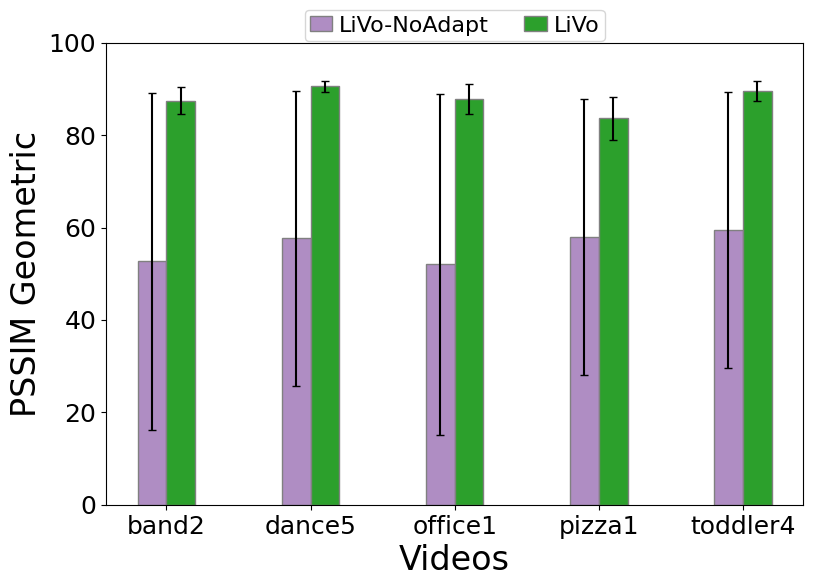

In [30]:
figsize = (9, 6)
fig, ax = plt.subplots(1, 1, figsize=figsize)

barWidth = 0.2

r1 = np.arange(len(seq_names))
r2 = np.array([x + barWidth for x in r1])

mean_starline_geo_with_stalls = [
    pssim_geo_dict[seq_name]["mean_starline_geo_with_stalls"] for seq_name in seq_names
]
std_starline_geo_with_stalls = [
    pssim_geo_dict[seq_name]["std_starline_geo_with_stalls"] for seq_name in seq_names
]
ax.bar(
    r1,
    mean_starline_geo_with_stalls,
    yerr=std_starline_geo_with_stalls,
    width=barWidth,
    edgecolor="grey",
    label="LiVo-NoAdapt",
    capsize=3,
    color="#af8dc3",
)

mean_livo_geo_with_stalls = [
    pssim_geo_dict[seq_name]["mean_livo_geo_with_stalls"] for seq_name in seq_names
]
std_livo_geo_withmean_livo_geo_with_stalls = [
    pssim_geo_dict[seq_name]["std_livo_geo_with_stalls"] for seq_name in seq_names
]
ax.bar(
    r2,
    mean_livo_geo_with_stalls,
    yerr=std_livo_geo_with_stalls,
    width=barWidth,
    edgecolor="grey",
    label="LiVo",
    capsize=3,
    color=colors[3],
)


ax.set_xticks(r1 + barWidth / 2)
ax.set_xticklabels(seq_names)
ax.set_ylabel("PSSIM Geometric", fontsize=xylabel_font)
ax.set_xlabel("Videos", fontsize=xylabel_font)
ax.set_ylim(0, 100)
ax.set_yticklabels(np.arange(0, 101, 20), fontsize=xytick_font)
ax.set_xticklabels(seq_names, fontsize=xytick_font)
legend = plt.legend(
    loc="upper center",
    handlelength=1,
    handletextpad=0.3,
    columnspacing=1.6,
    ncol=4,
    bbox_to_anchor=(0.5, 1.095),
    fontsize=legend_font,
    borderpad=0.25,
)

plt.show()

# Save figure to pdf file
fig.savefig(
    os.path.join(output_dir, "pssim_geo_starline_livo.pdf"),
    bbox_inches="tight",
)

# Comment: We get quality imporvement as a result of culling

/tmp/ipykernel_824424/2602833410.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0, 101, 20), fontsize=xytick_font)


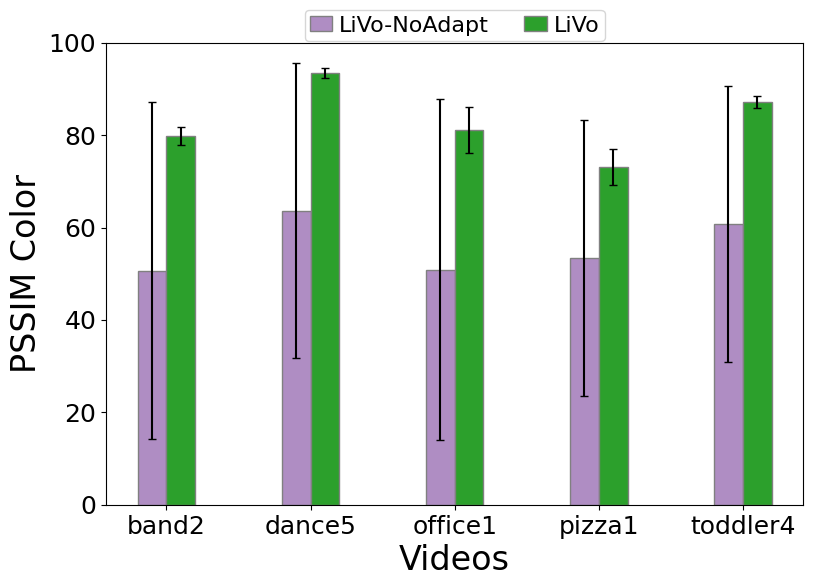

In [31]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

barWidth = 0.2

r1 = np.arange(len(seq_names))
r2 = np.array([x + barWidth for x in r1])


mean_starline_color_with_stalls = [
    pssim_color_dict[seq_name]["mean_starline_color_with_stalls"]
    for seq_name in seq_names
]
std_starline_color_with_stalls = [
    pssim_color_dict[seq_name]["std_starline_color_with_stalls"]
    for seq_name in seq_names
]
ax.bar(
    r1,
    mean_starline_color_with_stalls,
    yerr=std_starline_geo_with_stalls,
    width=barWidth,
    edgecolor="grey",
    label="LiVo-NoAdapt",
    capsize=3,
    color="#af8dc3",
)


mean_livo_color_with_stalls = [
    pssim_color_dict[seq_name]["mean_livo_color_with_stalls"] for seq_name in seq_names
]
std_livo_color_with_stalls = [
    pssim_color_dict[seq_name]["std_livo_color_with_stalls"] for seq_name in seq_names
]
ax.bar(
    r2,
    mean_livo_color_with_stalls,
    yerr=std_livo_color_with_stalls,
    width=barWidth,
    edgecolor="grey",
    label="LiVo",
    capsize=3,
    color=colors[3],
)


ax.set_xticks(r1 + barWidth / 2)
ax.set_xticklabels(seq_names)
ax.set_ylabel("PSSIM Color", fontsize=xylabel_font)
ax.set_xlabel("Videos", fontsize=xylabel_font)
ax.set_ylim(0, 100)
ax.set_yticklabels(np.arange(0, 101, 20), fontsize=xytick_font)
ax.set_xticklabels(seq_names, fontsize=xytick_font)
legend = plt.legend(
    loc="upper center",
    handlelength=1,
    handletextpad=0.3,
    columnspacing=1.6,
    ncol=4,
    bbox_to_anchor=(0.5, 1.095),
    fontsize=legend_font,
    borderpad=0.25,
)

plt.show()

# Save figure to pdf file
fig.savefig(
    os.path.join(output_dir, "pssim_color_starline_livo.pdf"),
    bbox_inches="tight",
)

# Comment: We get quality imporvement as a result of culling